In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import albumentations

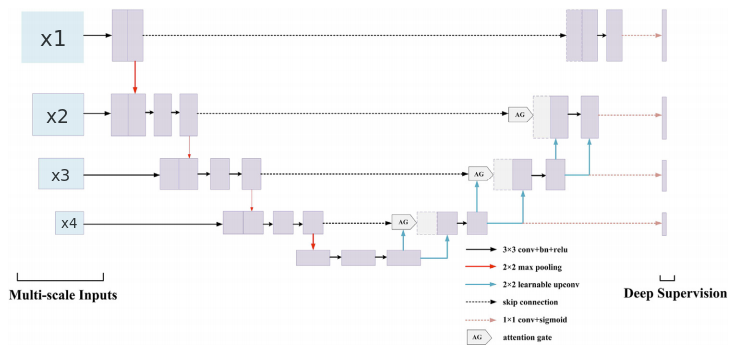

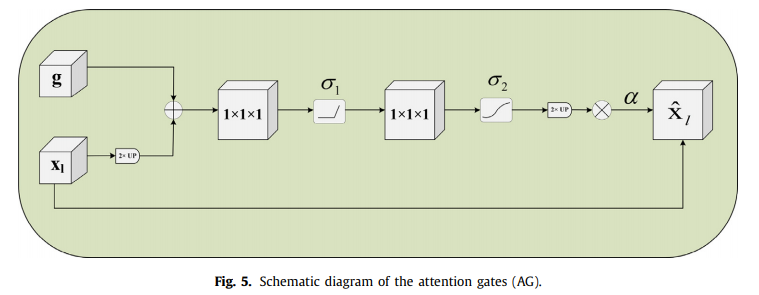

In [85]:
def conv3x3(ch_in, ch_out):
    return nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(ch_out),
        nn.ReLU(True)
    )


def conv1x1(ch_in, ch_out):
    return nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, bias=False),
        nn.Sigmoid()
    )


class attention_gate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(attention_gate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        """
        Example:
        ag = attention_gate(128, 256, 1024)
        ag(
            torch.ones((1, 128, 56, 56)),
            torch.ones((1, 256, 56, 56))
        )
        shape => torch.Size([1, 256, 56, 56])
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

    
class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [86]:
class GuidedUnet(nn.Module):
    def __init__(self, in_channels, channels, out_channels):
        super(GuidedUnet, self).__init__()
        
        self.conv_x1 = conv3x3(in_channels, channels)
        
        self.conv_x2 = conv3x3(in_channels, channels)
        self.conv_b2_2 = conv3x3(channels*2, channels)
        self.conv_b2_3 = conv3x3(channels, channels)
        
        self.conv_x3 = conv3x3(in_channels, channels)
        self.conv_b3_2 = conv3x3(channels*2, channels)
        self.conv_b3_3 = conv3x3(channels, channels)
        
        self.conv_x4 = conv3x3(in_channels, channels)
        self.conv_b4_2 = conv3x3(in_channels*2, channels)
        self.conv_b4_3 = conv3x3(channels, channels)
        
        self.conv_center_1 = conv3x3(channels, channels)
        self.conv_center_2 = conv3x3(channels, channels)
        
        self.up_center_2 = up_conv(channels, channels)
        
        self.ag_b4 = attention_gate(channels, channels, channels)
        self.up4_conv = conv3x3(channels*2, channels)
        self.up4_up = up_conv(channels, channels)
        self.up4_out = conv1x1(channels, out_channels)
        
        self.ag_b3 = attention_gate(channels, channels, channels)
        self.up3_conv = conv3x3(channels*2, channels)
        self.up3_up = up_conv(channels, channels)
        self.up3_out = conv1x1(channels, out_channels)
        
        self.ag_b2 = attention_gate(channels, channels, channels)
        self.up2_conv = conv3x3(channels*2, channels)
        self.up2_up = up_conv(channels, channels)
        self.up2_out = conv1x1(channels, out_channels)
        
        self.ag_b1 = attention_gate(channels, channels, channels)
        self.up1_conv = conv3x3(channels*2, channels)
        self.up1_out = conv1x1(channels, out_channels)
        
        self.max_pool = nn.MaxPool2d(2, 2)

    def forward(self, x1, x2, x3, x4):
        
        b1 = self.conv_x1(x1)
        b1_mp = self.max_pool(b1)
        
        b2_0 = self.conv_x2(x2)
        b2_1 = torch.cat((b2_0, b1_mp), 1)
        b2_2 = self.conv_b2_2(b2_1)
        b2_3 = self.conv_b2_3(b2_2)
        b2_mp = self.max_pool(b2_3)
        
        b3_0 = self.conv_x3(x3)
        b3_1 = torch.cat((b3_0, b2_mp), 1)
        b3_2 = self.conv_b3_2(b3_1)
        b3_3 = self.conv_b3_3(b3_2)
        b3_mp = self.max_pool(b3_3)
        
        b4_0 = self.conv_x3(x4)
        b4_1 = torch.cat((b4_0, b3_mp), 1)
        b4_2 = self.conv_b3_2(b4_1)
        b4_3 = self.conv_b3_3(b4_2)
        b4_mp = self.max_pool(b4_3)
        
        center_1 = self.conv_center_1(b4_mp)
        center_2 = self.conv_center_2(center_1)
        
        up_center_2 = self.up_center_2(center_2)
        ag_b4 = self.ag_b4(b4_3, up_center_2)
        up_4 = torch.cat((ag_b4, up_center_2), 1)
        up_4_convolved = self.up4_conv(up_4)
        up_4_out = self.up4_out(up_4_convolved)
        
        up_4_b3 = self.up4_up(up_4_convolved)
        ag_b3 = self.ag_b3(b3_3, up_4_b3)
        up_3 = torch.cat((ag_b3, up_4_b3), 1)
        up_3_convolved = self.up3_conv(up_3)
        up_3_out = self.up3_out(up_3_convolved)
        
        up_3_b2 = self.up3_up(up_3_convolved)
        ag_b2 = self.ag_b2(b2_3, up_3_b2)
        up_2 = torch.cat((ag_b2, up_3_b2), 1)
        up_2_convolved = self.up2_conv(up_2)
        up_2_out = self.up2_out(up_2_convolved)
        
        up_2_b1 = self.up2_up(up_2_convolved)
        ag_b1 = self.ag_b1(b1, up_2_b1)
        up_1 = torch.cat((ag_b1, up_2_b1), 1)
        up_1_convolved = self.up1_conv(up_1)
        up_1_out = self.up1_out(up_1_convolved)
        
        
        return [up_1_out, up_2_out, up_3_out, up_4_out]

In [87]:
GUnet = GuidedUnet(3, 64, 1)

sample_1 = torch.ones(6, 3, 224, 224)
sample_2 = torch.ones(6, 3, 112, 112)
sample_3 = torch.ones(6, 3, 56, 56)
sample_4 = torch.ones(6, 3, 28, 28)

out1, out2, out3, out4 = GUnet(sample_1, sample_2, sample_3, sample_4)
print(f"out1: {out1.shape}")
print(f"out2: {out2.shape}")
print(f"out3: {out3.shape}")
print(f"out4: {out4.shape}")

out1: torch.Size([6, 1, 224, 224])
out2: torch.Size([6, 1, 112, 112])
out3: torch.Size([6, 1, 56, 56])
out4: torch.Size([6, 1, 28, 28])


In [60]:
class TverskyLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        paper: https://arxiv.org/pdf/1706.05721.pdf
        """
        super(TverskyLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth
        self.alpha = 0.3
        self.beta = 0.7

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)


        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                tversky = tversky[1:]
            else:
                tversky = tversky[:, 1:]
        tversky = tversky.mean()

        return -tversky

class FocalTversky_loss(nn.Module):
    """
    paper: https://arxiv.org/pdf/1810.07842.pdf
    author code: https://github.com/nabsabraham/focal-tversky-unet/blob/347d39117c24540400dfe80d106d2fb06d2b99e1/losses.py#L65
    """
    def __init__(self, tversky_kwargs, gamma=0.75):
        super(FocalTversky_loss, self).__init__()
        self.gamma = gamma
        self.tversky = TverskyLoss(**tversky_kwargs)

    def forward(self, net_output, target):
        tversky_loss = 1 + self.tversky(net_output, target) # = 1-tversky(net_output, target)
        focal_tversky = torch.pow(tversky_loss, self.gamma)
        return focal_tversky
    
    
class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        paper: https://arxiv.org/pdf/1606.04797.pdf
        """
        super(SoftDiceLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc